# pyArgus
## Demonstation and documentation for the beamformer algorithms

License: GPLv3

Version: 1.0

Author: Tamás Pető

In [1]:
# Import pyArgus source files
from pyargus.antennaArrayPattern import array_rad_pattern_plot
import pyargus.beamform as bf
import pyargus.tests.beamformTest as bft
from pyargus.tests.patternPlotTest import demo_ULA_plot, demo_UCA_plot

import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

pyArgus beamformer module implements a number of different beamforming algorithms. The complete list of the algorithms is the following.

Fixed beamformers:
- Maximum Signal to Interference Ratio beamformer
- Maximum Signal to Interference Ratio beamformer with Godara's method

Adaptive beamformer:
- Optimum Wiener beamformer (with known signal of interest direction)
- MSINR with known covariance matrices
- MMSE with known signal of interest

Note that Maximum Signal to Interference plus Noise Ratio (MSINR), Minimum Mean Square Error (MMSE), Minimum Variance Distortionless Respone (MVDR), Maximum Likelihood (ML) optimization criterias lead to the same solution excepting a scalar scaling value. This solution is implemented as the optimum Wiener beamformer. For more detailes see [1].




## Fixed beamformers

### MSIR bemformer

In order to calculate the beampattern the incident angles of the interference sources must be known preliminiary. From these angles the array response matrix $\textbf{A}$ is created. Beside this, we must decide what response is required from the antenna system in the direction of these interference sources. This values is often selected to zero, thus we want to supress these interferences. These values are stored in the $\textbf{u}$ constraint vector. Then the $\textbf{w}$ coefficient vector can be calculated as follows [2]:

$$\textbf{w}_{MSIR}^H = \textbf{u} \textbf{A}^{-1}$$

The "fixed_max_sir_beamform" function implements this algorithm. Let us demonstrate its operation:


[[-4.33686917e-01-9.01063626e-01j -4.33686917e-01+9.01063626e-01j
  -3.82856870e-16+1.00000000e+00j  4.76182558e-01+8.79346446e-01j]
 [-6.23831317e-01+7.81559012e-01j -6.23831317e-01-7.81559012e-01j
  -1.00000000e+00-7.65713740e-16j -5.46500343e-01+8.37458879e-01j]
 [ 9.74781877e-01+2.23159790e-01j  9.74781877e-01-2.23159790e-01j
   7.04481400e-16-1.00000000e+00j -9.96650420e-01-8.17798235e-02j]
 [-2.21668977e-01-9.75121974e-01j -2.21668977e-01+9.75121974e-01j
   1.00000000e+00+1.53142748e-15j -4.02674749e-01-9.15343130e-01j]]


array([-8.68123548, -8.68130169, -8.68150036, ..., -8.68150036,
       -8.68130169, -8.68123548])

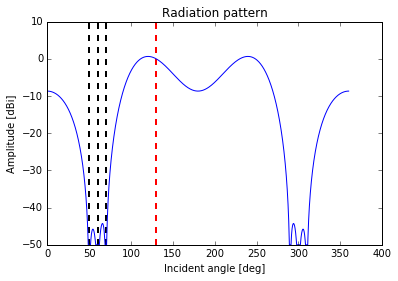

In [2]:
# Incident angle of the signal of interest is: 130 [deg]
# Incident angle of interferences are: 50,60,70 [deg]
par_angles = np.array([130, 50, 60, 70])  # Incident angle definition
par_constraints = np.array([1, 0, 0, 0]).reshape(4,1)  # Constraint vector definition
par_array_alignment = np.array([0.5, 1, 1.5, 2])  # Vector used to describe the antenna system

w_maxsir = bf.fixed_max_sir_beamform(par_angles, par_constraints, par_array_alignment)  # Calculate coefficients

# Plot the obtained beampattern
figure = plt.figure()        
ax = figure.add_subplot(111)

# mark incident angles on the figure
ax.axvline(linestyle = '--',linewidth = 2,color = 'r',x = 130)    
ax.axvline(linestyle = '--',linewidth = 2,color = 'black',x = 50)
ax.axvline(linestyle = '--',linewidth = 2,color = 'black',x = 60)
ax.axvline(linestyle = '--',linewidth = 2,color = 'black',x = 70)

array_alignment = np.array(([0.5, 1, 1.5, 2],[0, 0, 0, 0]))
array_rad_pattern_plot(w=w_maxsir, array_alignment = array_alignment, axes=ax)

The previously introduced beamformer can be applied only when the number of specified constraints is equal with the number antenna elements in the antenna system. In case it is not true, Godara's method may be applied.

$$\textbf{w}_{Godara} =  \textbf{u} \textbf{A}^{H} \left(\textbf{A} \textbf{A}^H + \sigma \textbf{I} \right)^{-1}$$

In the demonstration below, we have a quad channel linear antenna array. The number of interferences are less than the number of antenna elements so we can use Godara's method to deal with the interferences.

array([-4.98252176, -4.98257223, -4.98272365, ..., -4.98272365,
       -4.98257223, -4.98252176])

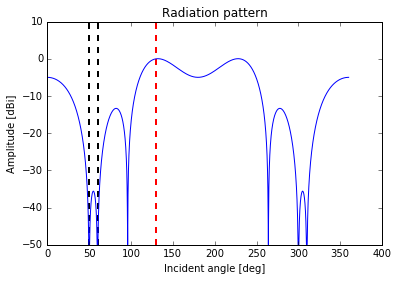

In [3]:
angles      = np.array([130,50,60])
constraints = np.array([1,0,0])
array_alignment = np.array([0.5, 1, 1.5, 2])

# Calculate coefficient vector
w_Godara_maxsir = bf.Goadar_max_sir_beamform(angles, constraints, array_alignment) 

# Plot the obtained beampattern
figure = plt.figure()        
ax = figure.add_subplot(111)

# mark incident angles on the figure
ax.axvline(linestyle = '--',linewidth = 2,color = 'r',x = 130)    
ax.axvline(linestyle = '--',linewidth = 2,color = 'black',x = 50)
ax.axvline(linestyle = '--',linewidth = 2,color = 'black',x = 60)

p_array_alignment = np.array(([0.5, 1, 1.5, 2],[0, 0, 0, 0]))
array_rad_pattern_plot(w = w_Godara_maxsir, array_alignment = p_array_alignment, axes =ax) 


# Adaptive beamformers

## MSINR (Maximum Signal to Noise Ratio)

The MSINR beamformer in its direct form use the spatial autocorrelation matrix of the signal of interest and the autocorrelation matrix of the interference sources to calculate the optimal weight coefficients. 
Note that in most practical cases these matrices are not available as the singal of interest and the interferences can not be separated.

The optimal coefficient vector in the Maximum Signal to Noise Ratio sense is equal with eigenvector belongs to the larges eigenvalue of the $\textbf{B}$ matrix.

$$\textbf{B} = \textbf{R}_{\nu\nu} \textbf{R}_{s}$$,
where $\textbf{R}_{\nu\nu}$ is the autocorrelation matrix of the noise plus interferences, while $\textbf{R}_{s}$ denotes the autocorrelation matrix of the signal of interest.

The following demonstration presents the operation of the MSINR beamformer.

Signal to interference and noise ratio : 1434.3535782044369


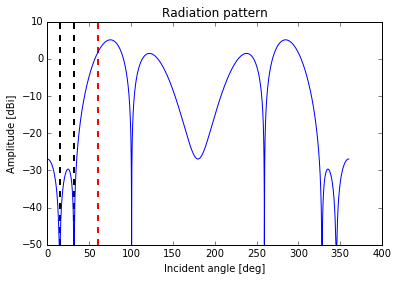

In [4]:
theta_soi = 60  # Incident angle of the signal of interest
theta_interf = np.array([15,32])  # Incident angles of the interferences

Pnoise   = 0.001              # noise variance  
d        = 0.5                # distance between antenna elements [lambda]
N        = 4                  # number of antenna elements

i = np.arange(N)

# Create array response vector for SOI
aS = np.exp(i*1j*2*np.pi*d*np.cos(np.deg2rad(theta_soi))) 
aS = np.matrix(aS).reshape(N,1)
# Create SOI autocorrelation matrix
Rss = aS * aS.getH() 

# Create interference autocorrelation matrix
Rnunu = np.matrix(np.zeros((N,N)))

for k in np.arange(np.size(theta_interf)):    
    aI = np.exp(i*1j*2*np.pi*d*np.cos(np.deg2rad(theta_interf[k])))  
    aI = np.matrix(aI).reshape(N,1)

    # Create interference autocorrelation matrix ( interferece signals are not correlated ) 
    Rnunu = Rnunu + aI * aI.getH()

# Create noise autocorrelation matrix
Rnn = np.matrix(np.eye(N)) * Pnoise

# Create noise + interferences autocorr matrix (interferences and thermal noise are not correlated)    
Rnunu = Rnunu + Rnn

# a figure instance to plot on
figure = plt.figure()

# create an axis
ax = figure.add_subplot(111)

# mark incident angles on the figure
ax.axvline(linestyle = '--',linewidth = 2,color = 'r',x = theta_soi)

for k in np.arange(np.size(theta_interf)):
    ax.axvline(linestyle = '--',linewidth = 2,color = 'black',x = theta_interf[k])


#Calculate MSINR solution
SINR,w_msinr = bf.MSINR_beamform(Rss,Rnunu)
w_msinr /= np.sqrt(np.dot(w_msinr,w_msinr.conj()))

p_array_alignment = np.array(([0.5, 1, 1.5, 2],[0, 0, 0, 0]))
pattern = array_rad_pattern_plot(w = w_msinr,axes = ax, array_alignment = p_array_alignment) 
print('Signal to interference and noise ratio :',np.abs(SINR))     

This demo is also wrapped into the "demo_msinr()" function where the incident angles can also be configured.

Signal to interference and noise ratio : 3674.374168094402


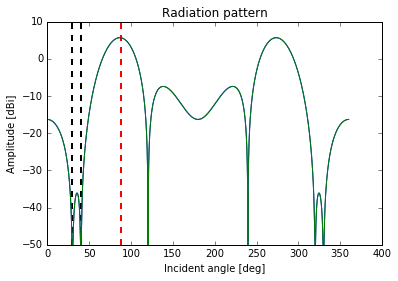

In [5]:
theta_soi = 88
theta_interf = np.array([30,40])
bft.demo_msinr(theta_soi, theta_interf)

## References

- [1] http://www.cwc.oulu.fi/nrs04/slides/mimo_BF&AA.pdf
- [2] Frank B Gross: Smart Antennas with MATLAB, 2nd edition, 2015